In [20]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!pip install opencv-python-headless tqdm

In [22]:
zip_path="/content/drive/MyDrive/GUVI/Miniproject5/SolarGuard/Solar_Panel_Dataset.zip"

In [23]:
!mkdir -p /content/drive/MyDrive/GUVI/Miniproject5/SolarGuard/Solar_Panel_Dataset_Extracted

In [25]:
# The 'unzip' command is pre-installed in Colab environments
print("Starting extraction...")
!unzip -q {zip_path} -d /content/drive/MyDrive/GUVI/Miniproject5/SolarGuard/Solar_Panel_Dataset_Extracted
print("Extraction complete!")

Starting extraction...
replace /content/drive/MyDrive/GUVI/Miniproject5/SolarGuard/Solar_Panel_Dataset_Extracted/Faulty_solar_panel/Physical-Damage/Physical (61).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Extraction complete!


In [26]:
drive_path="/content/drive/MyDrive/GUVI/Miniproject5/SolarGuard/Solar_Panel_Dataset_Extracted/Faulty_solar_panel"

In [27]:
import os
import cv2
import numpy as np
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [28]:
# Set a consistent seed value
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [29]:
target_size=(224,224)
classes=["Clean", "Dusty", "Bird-drop", "Electrical-damage", "Physical-Damage", "Snow-Covered"]
class_to_label={c:i for i,c in enumerate(classes)}
num_classes=len(classes)

# **Data Preparation**

In [30]:
def load_and_preprocess_data(data_dir, target_size, class_to_label,classes):
    """Loads, resizes, and normalizes images."""
    data = []
    labels = []

    print(f"Starting data loading from: {data_dir}")

    for class_name in tqdm(classes, desc="Processing Classes"):
        class_path = os.path.join(data_dir, class_name)
        # Using a more robust image file search
        image_files = glob.glob(os.path.join(class_path, '*.[jp][pn]g'))

        label = class_to_label[class_name]

        for file_path in image_files:
            try:
                # Load, Resize, Normalize
                image = cv2.imread(file_path)
                if image is None: continue
                resized_image = cv2.resize(image, target_size)
                normalized_image = resized_image.astype('float32') / 255.0

                data.append(normalized_image)
                labels.append(label)

            except Exception as e:
                print(f"Error loading {file_path}: {e}")
                continue

    return np.array(data), np.array(labels)
#Execute Data Loading
X_data,y_labels=load_and_preprocess_data(drive_path,target_size,class_to_label,classes)
print(f"\nTotal Images Loaded: {X_data.shape}")

Starting data loading from: /content/drive/MyDrive/GUVI/Miniproject5/SolarGuard/Solar_Panel_Dataset_Extracted/Faulty_solar_panel


Processing Classes: 100%|██████████| 6/6 [00:37<00:00,  6.21s/it]



Total Images Loaded: (804, 224, 224, 3)


# **Exploratory Data Analysis (EDA) & Visualization**


Class Distribution:
Clean: 184 images
Dusty: 190 images
Bird-drop: 169 images
Electrical-damage: 90 images
Physical-Damage: 66 images
Snow-Covered: 105 images


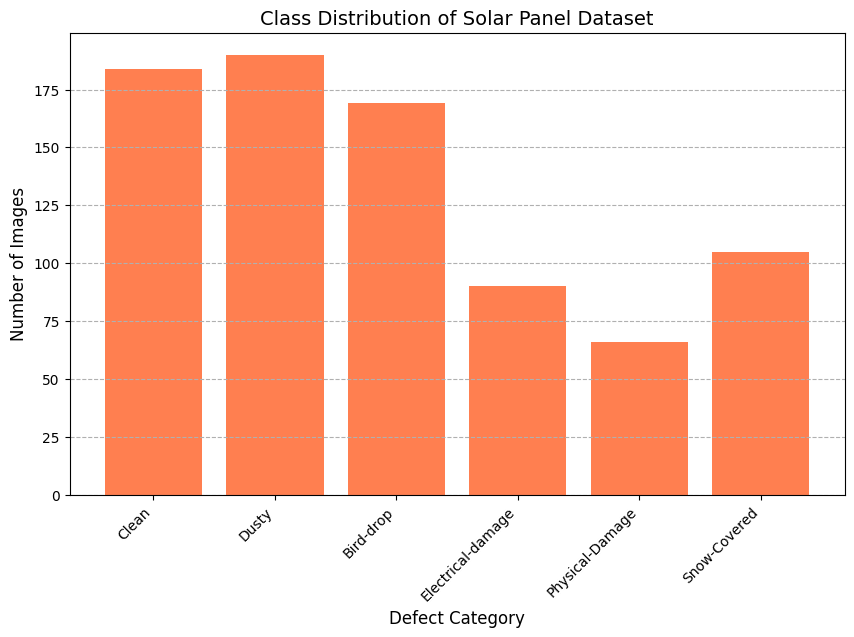

In [31]:
input_shape=(224,224,3)
#Class Distribution(Bar Chart)
unique_labels,counts=np.unique(y_labels,return_counts=True)
label_counts=dict(zip([classes[i] for i in unique_labels],counts))
print("\nClass Distribution:")
for cls, count in label_counts.items():
    print(f"{cls}: {count} images")

plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='coral')
plt.title('Class Distribution of Solar Panel Dataset', fontsize=14)
plt.xlabel('Defect Category', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.show()


--- Sample Image Visualization ---


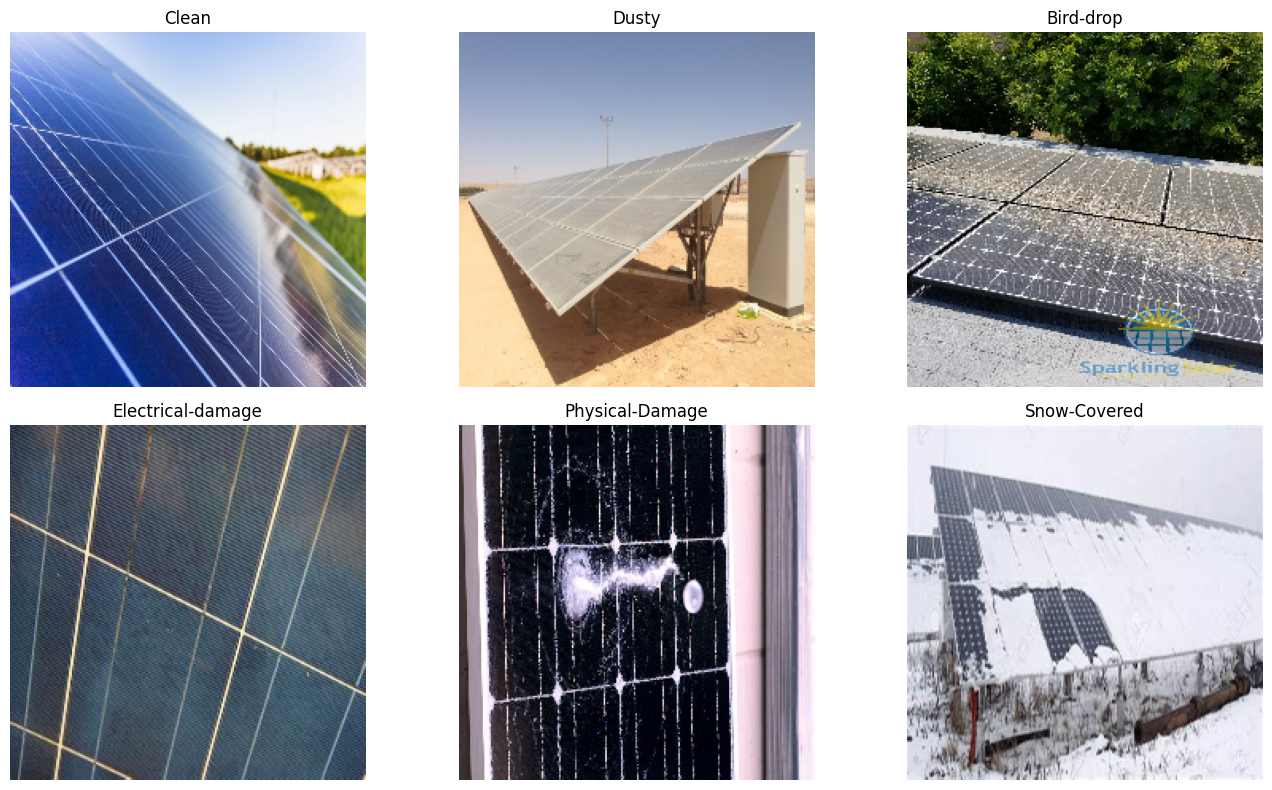

In [32]:
#  Visualize Sample Images per Class
print("\n--- Sample Image Visualization ---")
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, class_name in enumerate(classes):
    # Find the index of the first image belonging to this class
    try:
        index = np.where(y_labels == i)[0][0]
    except IndexError:
        print(f"Warning: No images found for class: {class_name}")
        continue

    # Convert BGR to RGB for Matplotlib display (X_data is 0-1 normalized)
    sample_image = cv2.cvtColor(X_data[index], cv2.COLOR_BGR2RGB)

    axes[i].imshow(sample_image)
    axes[i].set_title(class_name, fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# **Data Splitting (Train/Validation/Test 80/10/10)**

In [33]:
# Initial split: Train (80%) and Temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_data, y_labels,
    test_size=0.2,       # 20% for temporary set
    random_state=42,
    stratify=y_labels    # Ensures class ratios are preserved
)

# Second split: Temp (20%) into Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,       # Splits the 20% into two 10% sets
    random_state=42,
    stratify=y_temp
)
# Convert labels to one-hot encoding for Keras
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
# y_test remains label encoded for evaluation later

print("\n--- Data Splitting Complete ---")
print(f"Training Data (X_train): {X_train.shape}, Labels (y_train_cat): {y_train_cat.shape}")
print(f"Validation Data (X_val): {X_val.shape}, Labels (y_val_cat): {y_val_cat.shape}")
print(f"Testing Data (X_test): {X_test.shape}, Labels (y_test): {y_test.shape}")


--- Data Splitting Complete ---
Training Data (X_train): (643, 224, 224, 3), Labels (y_train_cat): (643, 6)
Validation Data (X_val): (80, 224, 224, 3), Labels (y_val_cat): (80, 6)
Testing Data (X_test): (81, 224, 224, 3), Labels (y_test): (81,)


# **Model Setup (MobileNetV2 Transfer Learning)**

In [34]:
# --- Model Configuration ---
input_shape = (224, 224, 3)

# Load the MobileNetV2 base model
# include_top=False strips the original classification layer
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# Freeze the base layers for the initial rapid training phase
base_model.trainable = False

# Build the final classification model (Sequential is simple and effective)
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'), # A hidden layer to learn new features
    Dropout(0.5),                  # Dropout for regularization
    Dense(num_classes, activation='softmax') # 6-class output layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Classification Model Architecture ---")
model.summary()



--- Classification Model Architecture ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    32,113,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,374,214 (131.13 MB)

 Trainable params: 32,116,230 (122.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# **Model Training and Evaluation**

In [35]:
#Define Data Augmentation Generator
# This generates augmented images on-the-fly for the training data
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create the training generator
batch_size = 32
train_generator = train_datagen.flow(
    X_train, y_train_cat,
    batch_size=batch_size
)


In [38]:
#Define Callbacks
weights_path="/content/drive/MyDrive/GUVI/Miniproject5/SolarGuard/best_classification_weights.weights.h5"
# Early Stopping: Stop training if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Model Checkpoint: Save the best performing model based on validation loss
model_checkpoint = ModelCheckpoint(
    filepath=weights_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    save_weights_only=True
)

print("Starting model training...")

#  Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size, # Use the whole dataset once per epoch
    epochs=50, # Set a high number, EarlyStopping will manage the actual epochs
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stopping, model_checkpoint]
)

print(f"\nBest weights saved to: {weights_path}")
print("Training finished.")



Starting model training...
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6163 - loss: 4.0954
Epoch 1: val_loss improved from inf to 0.88226, saving model to /content/drive/MyDrive/GUVI/Miniproject5/SolarGuard/best_classification_weights.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.6169 - loss: 4.0301 - val_accuracy: 0.7000 - val_loss: 0.8823
Epoch 2/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 1:14 4s/step - accuracy: 0.7188 - loss: 0.8449
Epoch 2: val_loss improved from 0.88226 to 0.85182, saving model to /content/drive/MyDrive/GUVI/Miniproject5/SolarGuard/best_classification_weights.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 561ms/step - accuracy: 0.7188 - loss: 0.8449 - val_accuracy: 0.6750 - val_loss: 0.8518
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6787 - loss: 1.0147
Epoch 3: val_loss did not improve from 0.85182
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.6783 - loss: 1.0141 - val_accuracy: 0.6375 - val_loss: 0.9208
Epoch 4/50
 1

In [39]:
# Load Best Weights for Final Evaluation
# The EarlyStopping callback has already restored the best weights,
# but we explicitly load the saved file's weights for deployment consistency.
try:
    model.load_weights(weights_path)
    print("Best weights successfully loaded into the model for final evaluation.")
    best_model = model # Use a new variable for clarity in evaluation
except Exception as e:
    print(f"Error loading best weights: {e}")
    best_model = model # Fallback to the weights restored by EarlyStopping


Best weights successfully loaded into the model for final evaluation.


In [40]:
# Final Evaluation on Test Set
print("\n--- Model Evaluation on Test Set ---")
# Ensure X_test and y_test are defined in a prior cell
loss,accuracy=best_model.evaluate(X_test,to_categorical(y_test,num_classes=len(classes)),verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

#Generate Predictions
y_prob=best_model.predict(X_test,verbose=0)
y_pred_classes=np.argmax(y_prob,axis=1)

#Calculate Classification Report
print("\n--- Classification Report ---")
report=classification_report(y_test,y_pred_classes,target_names=classes,zero_division=0)
print(report)



--- Model Evaluation on Test Set ---
Test Loss: 0.9216
Test Accuracy: 70.37%

--- Classification Report ---
                   precision    recall  f1-score   support

            Clean       0.63      0.89      0.74        19
            Dusty       0.63      0.63      0.63        19
        Bird-drop       0.60      0.53      0.56        17
Electrical-damage       0.86      0.67      0.75         9
  Physical-Damage       1.00      0.83      0.91         6
     Snow-Covered       1.00      0.73      0.84        11

         accuracy                           0.70        81
        macro avg       0.79      0.71      0.74        81
     weighted avg       0.73      0.70      0.70        81




--- Confusion Matrix Plot ---


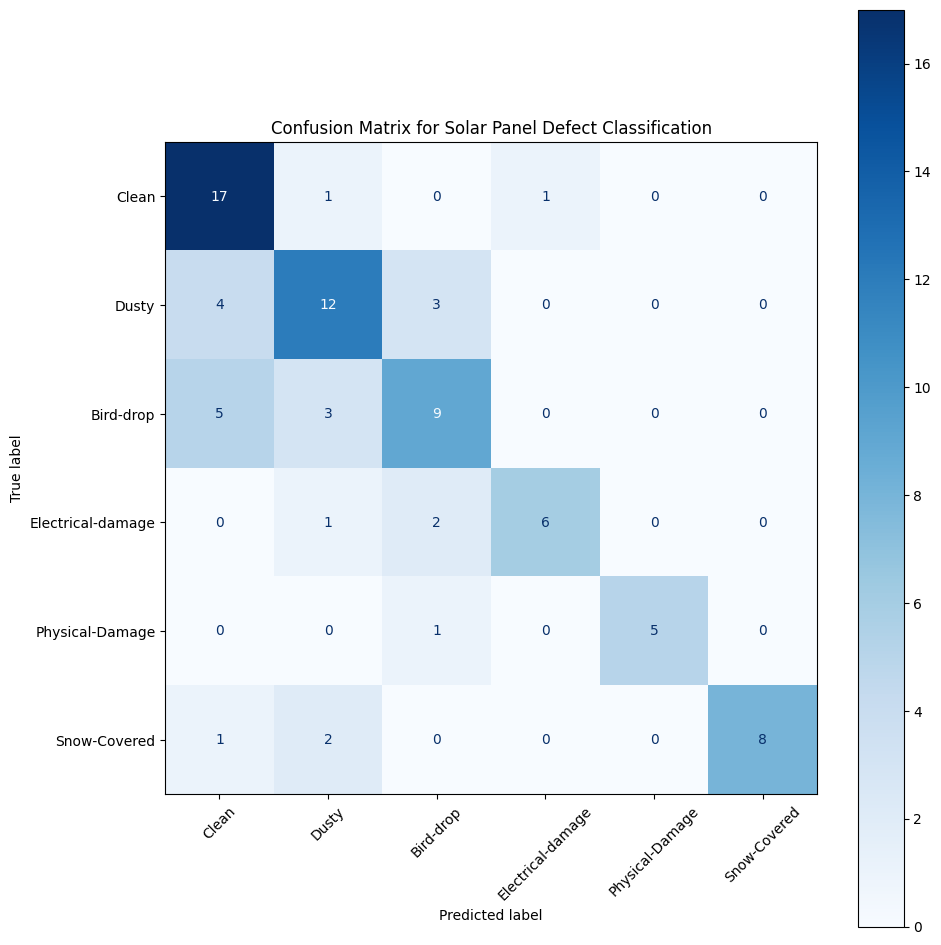

In [41]:
#Visualization: Confusion Matrix Plot
print("\n--- Confusion Matrix Plot ---")
cm=confusion_matrix(y_test,y_pred_classes)
fig,ax=plt.subplots(figsize=(10,10))
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot(cmap=plt.cm.Blues,ax=ax,xticks_rotation=45)
plt.title("Confusion Matrix for Solar Panel Defect Classification")
plt.tight_layout()
plt.show()